# predict

(10000, 1, 28, 28)
(10000, 1, 28, 28)


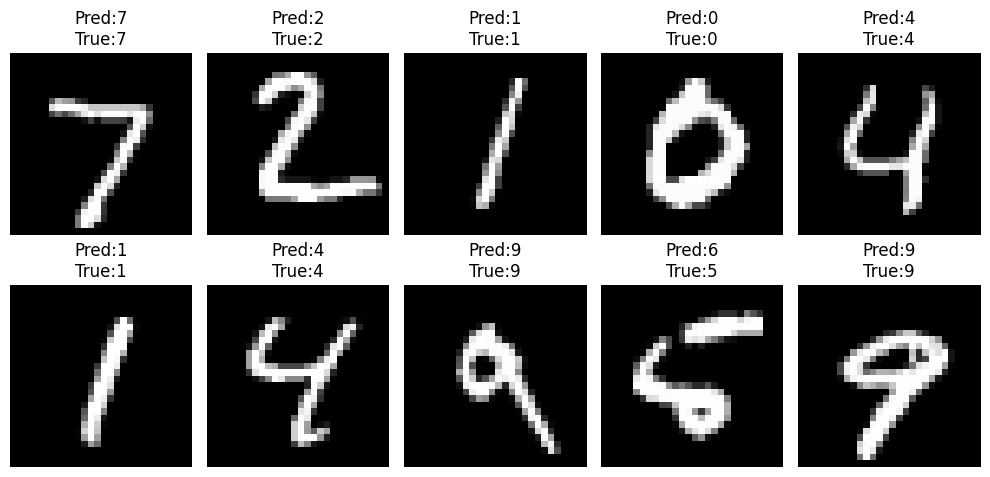

Loss:0.02985094722205722, Accuracy: 0.9903


In [3]:
import numpy as np
import pickle
from VGG_like import VGG_like
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt


def makedataset():
    """
    make dataset from MNIST
    """
    (X_train, y_train),(X_test, y_test) = mnist.load_data()
    lb = LabelBinarizer()
    
    
    # 正規化
    test_data = (X_test - X_test.min()) / X_test.max()
    test_label = lb.fit_transform(y_test)
    
    # 画像にチャンネルを追加
    test_data = np.expand_dims(test_data, axis=1)
    print(test_data.shape) 
    # 配列形式変更
    test_data = test_data.reshape(-1,1, 28,28)
    print(test_data.shape)
    
    # テストデータを返す.
    return test_data, test_label


def func_predict(test_data, test_label):
    """
    予測する関数
    data : 画像データ
    return loss, accuracy
    引数とreturn以外は、自由に編集してください    
    """

    model = VGG_like(input_dim=(1, 28, 28),
                conv_param={'filter_size':3, 'pad':1, 'stride':1},
                pool_param={'pool_size':2, 'pad':0, 'stride':2},
                output_size=10, weight_init_std=0.01)
    with open('model_epoch0_acc0.99_loop2.pkl', 'rb') as f:
        save_dict = pickle.load(f)
        loaded_params = save_dict['params']
        bn_stats = save_dict['bn_stats']

        # パラメータをモデルに反映
        model.params = loaded_params

        # Conv層のパラメータ設定
        for i in range(1, 8):  # Conv層が1～7層ある場合
            model.layers['Conv' + str(i)].W = model.params['W' + str(i)]
            model.layers['Conv' + str(i)].b = model.params['b' + str(i)]

        # バッチ正規化層のパラメータ設定
        for block_idx in range(1, 5):
            gamma_name = f'gamma_block{block_idx}'
            beta_name = f'beta_block{block_idx}'
            if gamma_name in model.params and beta_name in model.params:
                model.layers[f'BatchNorm_block{block_idx}'].gamma = model.params[gamma_name]
                model.layers[f'BatchNorm_block{block_idx}'].beta = model.params[beta_name]
                # running_mean と running_var の設定
                model.layers[f'BatchNorm_block{block_idx}'].moving_mean = bn_stats[f'BatchNorm_block{block_idx}']['moving_mean']
                model.layers[f'BatchNorm_block{block_idx}'].moving_var = bn_stats[f'BatchNorm_block{block_idx}']['moving_var']
            else:
                print("バッチ正規化パラメータの復元に失敗しました")

        # 全結合層のパラメータ設定
        model.layers['Affine_fc1'].W = model.params['W_fc1']
        model.layers['Affine_fc1'].b = model.params['b_fc1']
        model.layers['Affine_fc3'].W = model.params['W_fc3']
        model.layers['Affine_fc3'].b = model.params['b_fc3']
        
    
    # 予測した最初の10枚と予測結果を表示する.
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,i+1)
        Predicted_labels = np.argmax(model.predict(np.expand_dims(test_data[i],axis=0)))
        Truelabels = np.argmax(test_label[i])
        plt.imshow(test_data[i].reshape(28,28), cmap='gray')
        plt.title(f"Pred:{Predicted_labels}\nTrue:{Truelabels}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    accuracy = model.accuracy(test_data, test_label)
    loss  = model.loss(test_data, test_label)

    return loss, accuracy # 編集不可


def main():
    """
    Main fuction.
    """
    # テスト用データをつくる
    test_data, test_label = makedataset()
    
    
    # 予測し精度を算出する
    loss, accuracy = func_predict(test_data, test_label)
    print(f"Loss:{loss}, Accuracy: {accuracy}")
    
    


if __name__=="__main__":
    main()